In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle5 as pickle
from collections import defaultdict

In [5]:
#file = open('../../Results/Densities/June_6_2023/06062023.pkl', 'rb')
file = open('../../../Production/Results/01413827_RH/1690957461.pkl', 'rb')
df = pickle.load(file)

In [6]:
# REmove NaN values
df = df.dropna()

In [7]:
image_names = np.unique(df['image'] )

In [8]:
# compute the average cell density
densities=defaultdict(list)

for image in image_names:
    image_data = df[df['image']==image].to_numpy()[:,[1,2]]
    for depth, value  in zip(image_data[:,0],image_data[:,1]):
        densities[depth].append(value)


In [9]:
average={}
median={}
for key, value in densities.items():
    average[key] = np.average(value)
    median[key] = np.median(value)
    
#main_average = np.array(average)

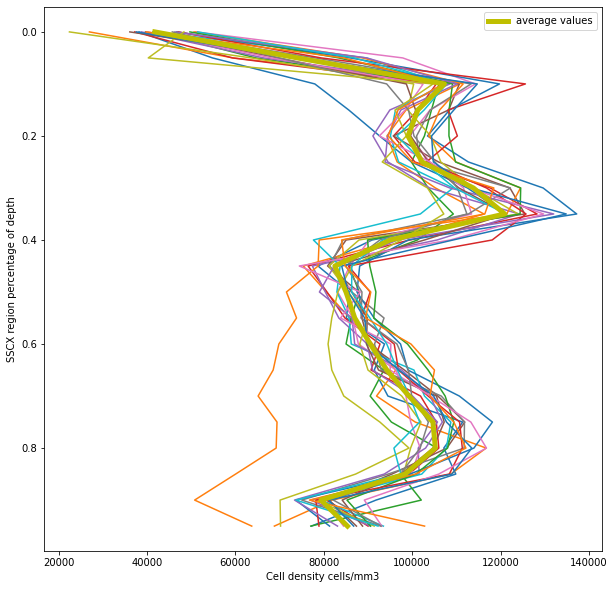

In [19]:
plt.figure(figsize=(10,10))
for image in image_names:
    image_data = df[df['image']==image].to_numpy()[:,[1,2]]
    plt.plot(image_data[:,1], image_data[:,0])
plt.plot(list(average.values()), list(average.keys()), linewidth=5, c='y', label='average values')
#plt.plot(list(median.keys()),list(median.values()), linewidth=5, c='black', label='median values')
#plt.title('Cell density as a function of SSCX region percentage of depth.')
plt.gca().set_ylabel("SSCX region percentage of depth")
plt.gca().set_xlabel("Cell density cells/mm3")
plt.title('01413827_RH Cell density as percentage of brain depth')
plt.gca().invert_yaxis()
plt.legend()
    